# Machine Learning 0 - Introduction

In this lab, we will introduce the classification problem that we will be working on for the last three labs. The objectives of the lab are:

* Examine the dataset and prepare the basic pipeline that will be used in the next lab.
* Make sure that we use a correct methodology for comparing the algorithms
* Get used to working with the [scikit-learn](https://scikit-learn.org/stable/) library.

## Important note

For the machine learning labs, **each student must write a report** (one report for all labs together) which will be used during the oral exam. This report should highlight the different methods used during the labs, but also how you validated each method and compared their results.

## Introduction to the dataset

The [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset has been collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. It consists of 60.000 32x32 colour images, split in 10 classes: 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'.

*Reference: Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009.* PDF available at https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf

For the purpose of the INFO-H-501 laboratories, we will use a subset of those images by only taking 3 different classes: 'airplane', 'bird' and 'horse'.

[Click here to download](https://my.pcloud.com/publink/show?code=XZJUCPkZqiVxqtn8CXRB7D78YKt88RJvzWyk) the modified dataset. Extract the ZIP file and put the CIFAR10 folder in the same directory as the notebook.

The images are 32x32 8-bit **RGB**, and from these we extracted **Histogram of Gradient** vectors (16 orientations x 16 blocks = 256 values in HoG vector).

The following code pre-loads all of this data (make sure that you have the [lab_tools.py](https://github.com/odebeir/info-h-500-501/blob/master/LABS1/lab_tools.py) file in the same directory as the notebook, if you didn't clone the repository):

In [1]:
from lab_tools import CIFAR10, get_hog_image

Pre-loading training data
Pre-loading test data


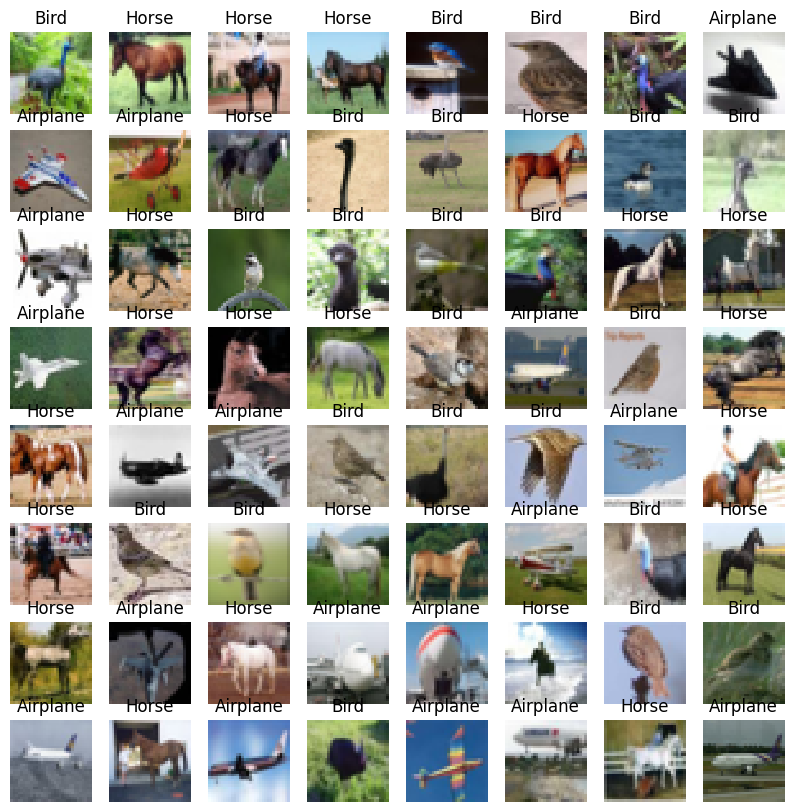

In [2]:
dataset = CIFAR10('./CIFAR10/')
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,10))
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.imshow(dataset.train['images'][i].reshape((32,32,3)), interpolation='none')
    plt.title(dataset.labels[dataset.train['labels'][i]])
    plt.axis('off')
plt.show()

We can also have a look at some HoG images:

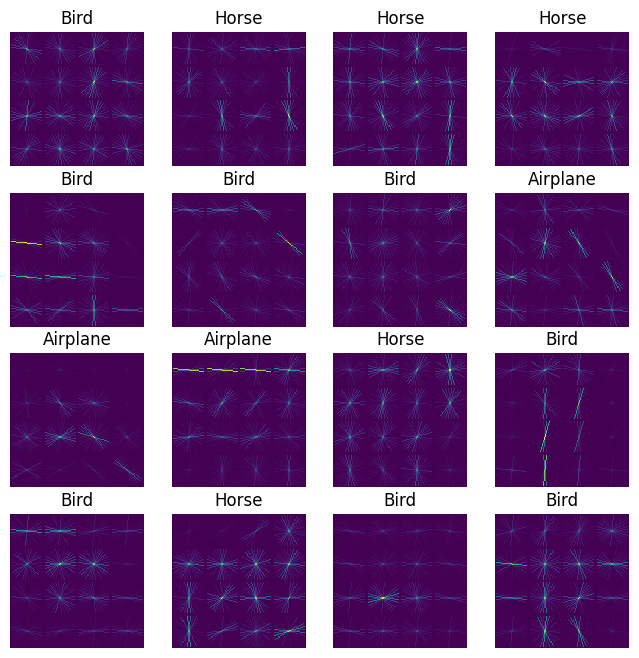

In [49]:
plt.figure(figsize=(8,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    hog = dataset.train['hog'][i].reshape((4,4,16))
    plt.imshow(get_hog_image(hog, 128), interpolation='none')
    plt.title(dataset.labels[dataset.train['labels'][i]])
    plt.axis('off')
plt.show()

Note that this is an "image" representation of the HoG, but that the actual data that we will be working on is a size 256 vector for each image. Our **feature space** has therefore 256 dimensions. 

## Exploring the dataset

The *dataset* object gives you access to different attributes:

* *dataset.path* contains the path to the CIFAR10 folder.
* *dataset.labels* contains the name of the three classes
* *dataset.train* and *dataset.test* are dictionaries containing three numpy arrays each:
    * *images* contains the RGB images
    * *hog* contains the HoG vectors
    * *labels* contains the label for each image

In [50]:
print(dataset.path)
print(dataset.labels)
print(dataset.train.keys())
print(dataset.train['hog'].shape)

./CIFAR10/
['Airplane', 'Bird', 'Horse']
dict_keys(['images', 'hog', 'labels'])
(15000, 256)


### Quick questions:

The dataset has already been split into a training set (dataset.train) and a test set (dataset.test).

* How many images are in the training set ?
* How many images are in the test set ?
* What is the class distribution of the dataset ?

In [51]:
size_train = dataset.train['images'].shape[0]
size_test = dataset.test['images'].shape[0]

print(f'{size_train} images in the training dataset')
print(f'{size_test} images in the test dataset \n')


for id,label in enumerate(dataset.labels):
    size = (dataset.train['labels'] == id).sum()
    print(f'{size} images of label {label} in the training dataset')
print('\n')    
for id,label in enumerate(dataset.labels):
    size = (dataset.test['labels'] == id).sum()
    print(f'{size} images of label {label} in the test dataset')   
    
    
# the dataset is balanced in the training AND the test

15000 images in the training dataset
3000 images in the test dataset 

5000 images of label Airplane in the training dataset
5000 images of label Bird in the training dataset
5000 images of label Horse in the training dataset


1000 images of label Airplane in the test dataset
1000 images of label Bird in the test dataset
1000 images of label Horse in the test dataset


### Descriptive data analysis

Look at the HoG data from the training set. What are the characteristics of the dataset ? Do you think that some pre-processing may be required to help with the different algorithms ?

In [52]:
# We need to look if the range of distribution is different from one class to the other
# -> could have an impact on the classifier

(256,)


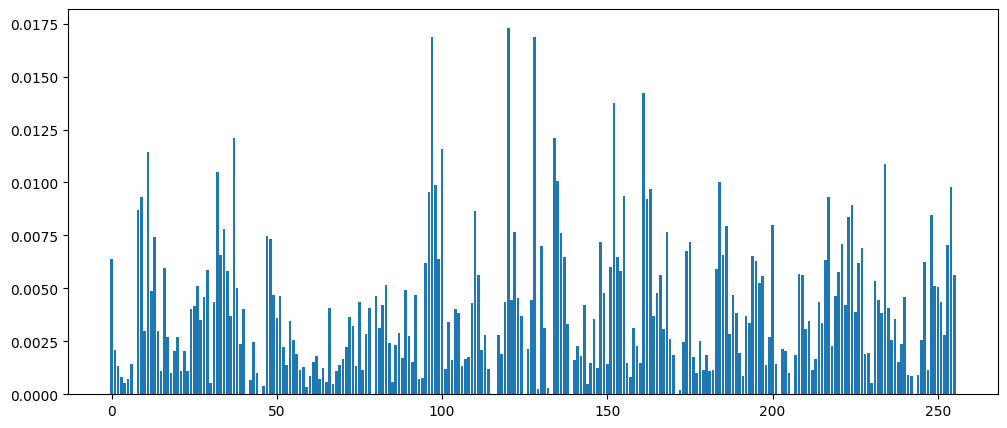

In [53]:
print(dataset.train['hog'][0].shape)

plt.figure(figsize=(12,5))
plt.bar(range(256),dataset.train['hog'][0])
plt.show()


# First we see that all the values are positive, could have an impact for certain classifier
# All the values seem also very small
 

Column 0:
Mean: 0.004343110381111906
Std: 0.005326996834501729
Column 50:
Mean: 0.0016703253545152497
Std: 0.002868141280326547
Column 100:
Mean: 0.005727461243256102
Std: 0.008012191030212702
Column 150:
Mean: 0.006154202929525623
Std: 0.0070548348769904545
Column 200:
Mean: 0.0076809946674200715
Std: 0.008004209388457702


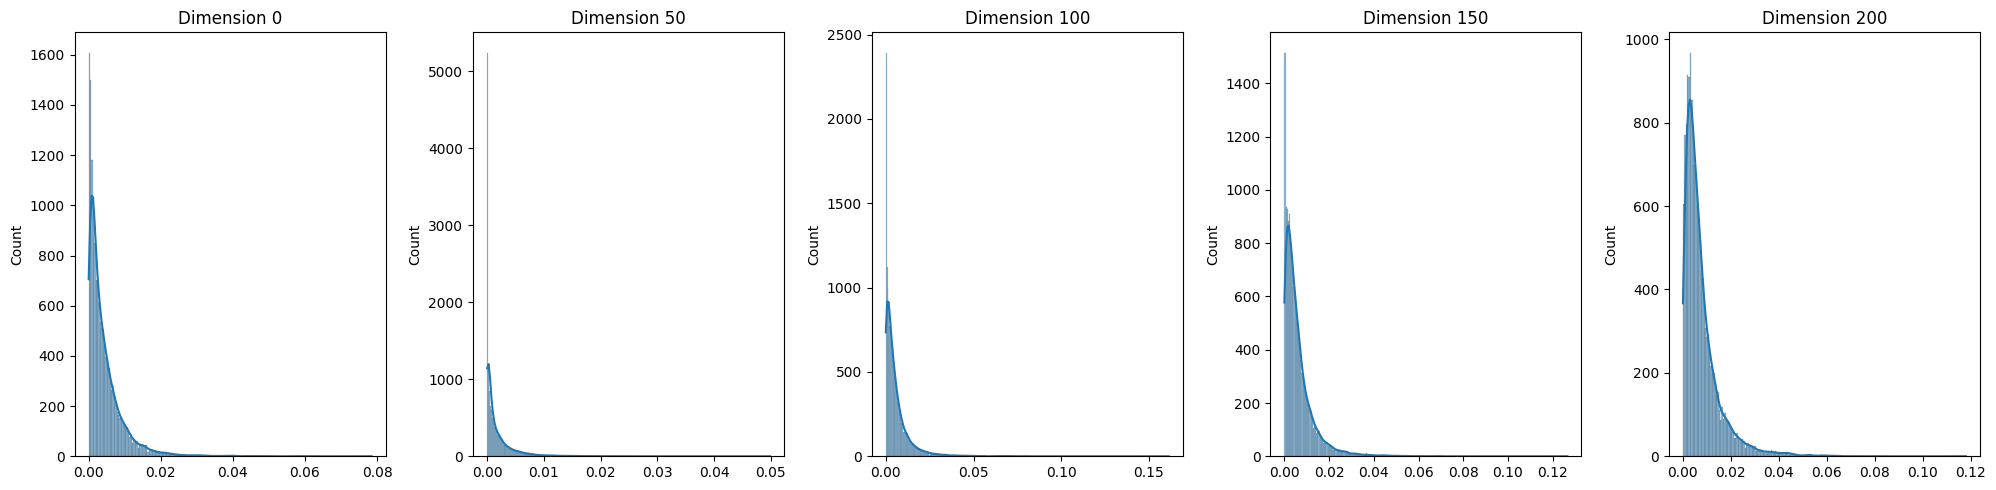

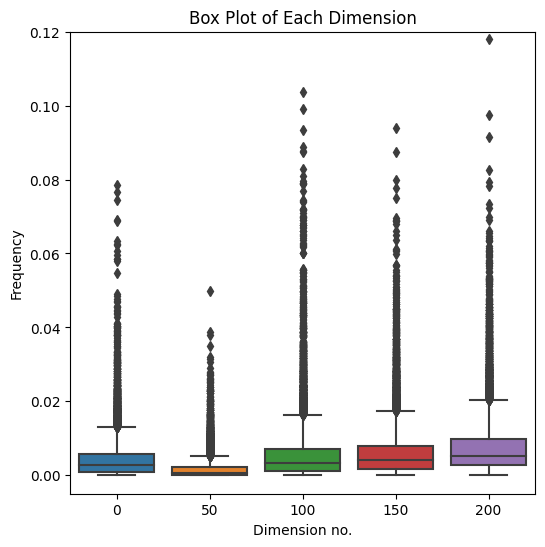

In [50]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = dataset.train['hog'][:, [0, 50, 100, 150, 200]]


# Visualize the distribution of each dimension
fig, axes = plt.subplots(1, data.shape[1], figsize=(20, 5))

for i in range(data.shape[1]):
    sns.histplot(data[:, i], kde=True, ax=axes[i])
    axes[i].set_title(f'Dimension {(i)*50}')
    
    print(f'Column {i*50}:')
    print(f'Mean: {np.mean(data[:, i])}')
    print(f'Std: {np.std(data[:, i])}')

plt.tight_layout()
plt.show()

# Alternatively, you can use box plots to compare distributions
plt.figure(figsize=(6, 6))
sns.boxplot(data=data)
plt.title('Box Plot of Each Dimension')
plt.xlabel('Dimension no.')
plt.ylabel('Frequency')
plt.ylim([-0.005,0.12])
plt.xticks([0,1,2,3,4], [0,50,100,150,200])
plt.show()


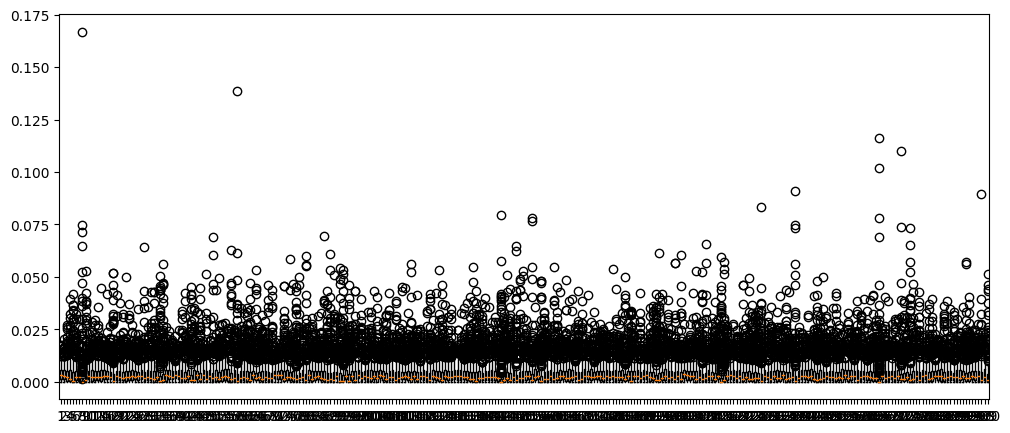

In [54]:
plt.figure(figsize=(12,5))
plt.boxplot(dataset.train['hog'][::50].T)
plt.show()


# The means and the main percentiles are at the same point and the outliers don't go that far so we can say
# that the dimensions are all in the same range, same distribution

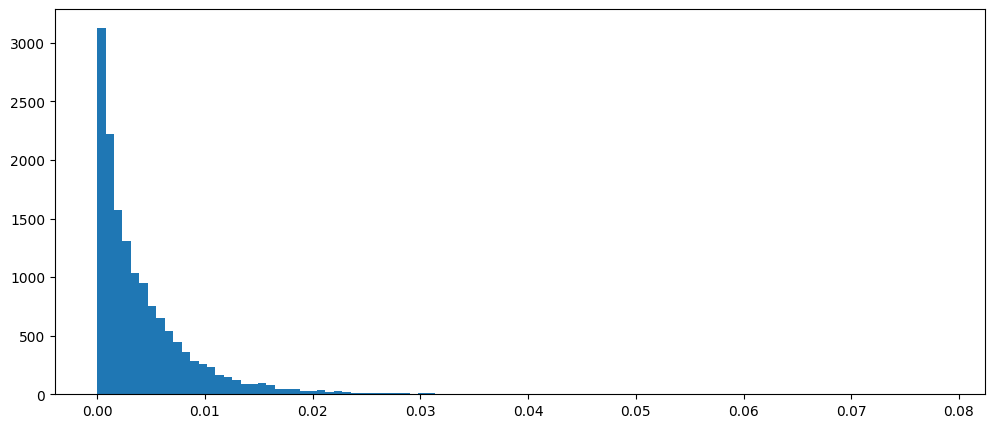

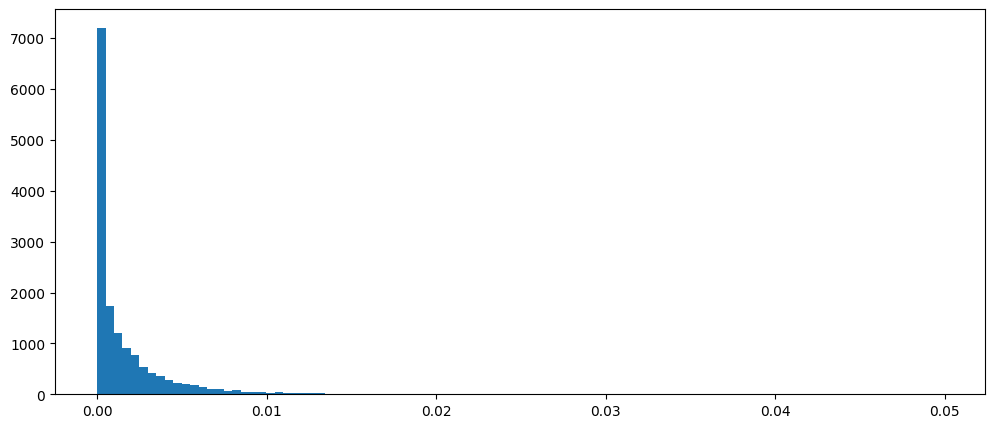

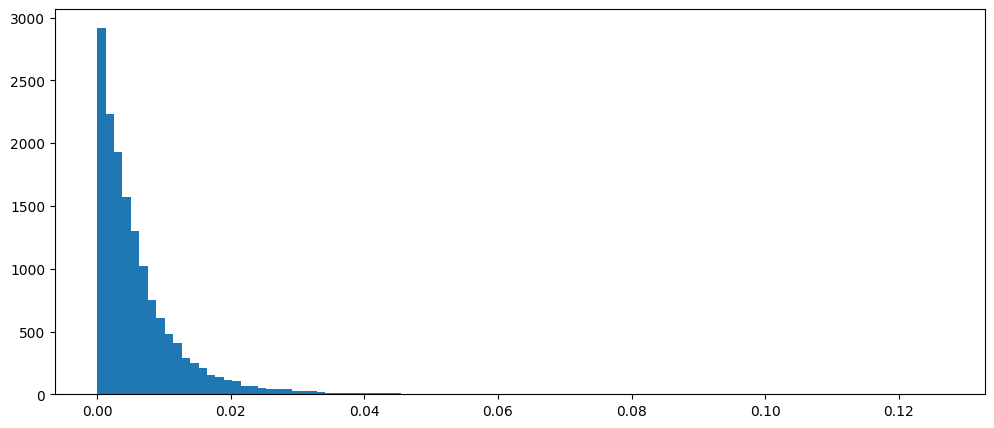

In [55]:
plt.figure(figsize=(12,5))
plt.hist(dataset.train['hog'][:,0], bins=100)
plt.figure(figsize=(12,5))
plt.hist(dataset.train['hog'][:,50], bins=100)
plt.figure(figsize=(12,5))
plt.hist(dataset.train['hog'][:,150], bins=100)
plt.show()

# We can see that we have a similar distribution amongst the features across the entire training set

# however, data is not centered on the origin which some classifier want
#But in general, data is quite nice, no need for a lot of preprocessing

In [56]:
# We can look at the correlation between the different dimensions to see how much we could expect from dimensions reduction
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


list = []

for hog in dataset.train['hog']:
    list.append(hog)
    
df = pd.DataFrame(list)

print(df.shape)

(15000, 256)


In [57]:
# Classifier based on metrics prefer to have not to much dimensions, so if dimesnions are heavy correlated 
# it would be possible to reduce the dimensions by a lot so useful for certain classifiers
# (like nearest neighbours)

In [58]:
correlation_matrix = df.corr()

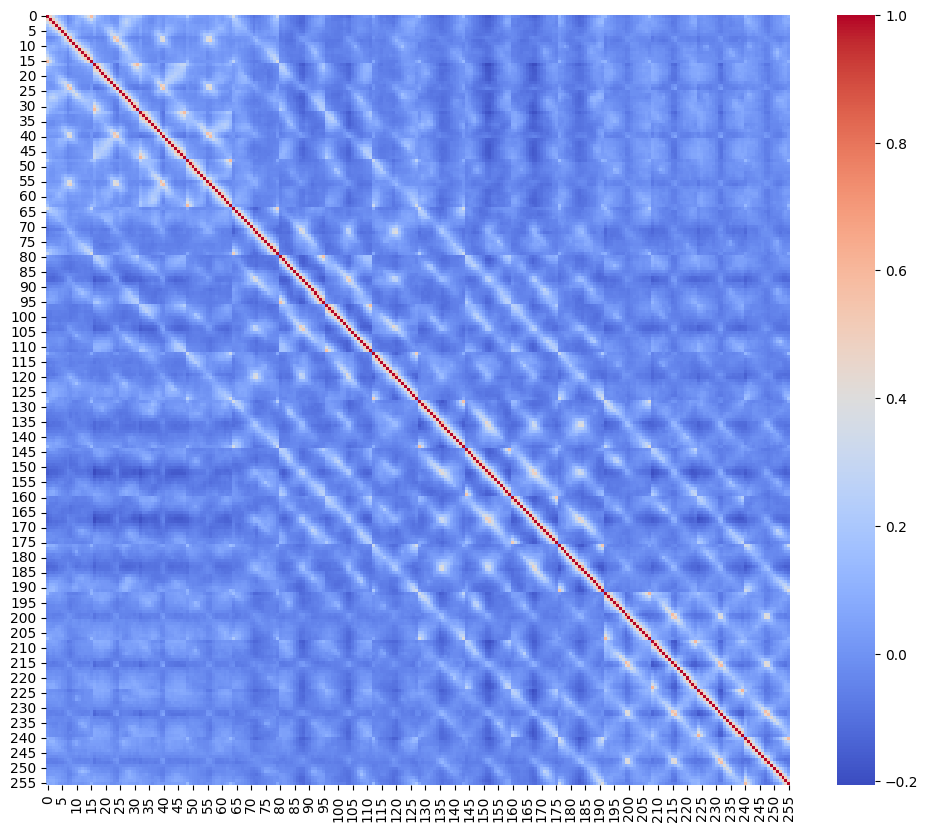

In [59]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f")
plt.show()

In [ ]:
## Normalization in a [0,1] interval

In [3]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_01_train = scaler.fit_transform(dataset.train['hog'])
normalized_01_test = scaler.fit_transform(dataset.test['hog'])

In [5]:
print(normalized_01_train.shape)
print(normalized_01_train.max(axis=0).max())
print(normalized_01_train.min(axis=0).min())

(15000, 256)
1.0
0.0


In [ ]:
## Normalization in a [-1,1] interval

In [6]:
scaler = MinMaxScaler(feature_range=(-1, 1))
normalized_11_train = scaler.fit_transform(dataset.train['hog'])
normalized_11_test = scaler.fit_transform(dataset.test['hog'])

In [7]:
print(normalized_11_train.shape)
print(normalized_11_train.max(axis=0).max())
print(normalized_11_train.min(axis=0).min())

(15000, 256)
1.0
-1.0


In [ ]:
## Perfom PCA

In [8]:
from sklearn.decomposition import PCA

In [9]:
pca = PCA(n_components=0.80)

PCA_train = pca.fit_transform(normalized_01_train)
PCA_test = pca.transform(normalized_01_test)

In [10]:
print(PCA_train.shape)
print(PCA_train.max(axis=0).max())
print(PCA_train.min(axis=0).min())
print(PCA_test.shape)
print(PCA_test.max(axis=0).max())
print(PCA_test.min(axis=0).min())

(15000, 116)
1.1091062857756568
-0.7826208610830095
(3000, 116)
1.2691781141414178
-0.9675240988040121


In [ ]:
## PCA then normalized [0,1]

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
PCA_01_train = scaler.fit_transform(PCA_train)
PCA_01_test = scaler.fit_transform(PCA_test)

In [13]:
print(PCA_01_train.shape)
print(PCA_01_train.max(axis=0).max())
print(PCA_01_train.min(axis=0).min())

(15000, 116)
1.0000000000000002
0.0


In [ ]:
## PCA then normalized [-1,1]

In [14]:
scaler = MinMaxScaler(feature_range=(-1, 1))
PCA_11_train = scaler.fit_transform(PCA_train)
PCA_11_test = scaler.fit_transform(PCA_test)

In [15]:
print(PCA_11_train.shape)
print(PCA_11_train.max(axis=0).max())
print(PCA_11_train.min(axis=0).min())

(15000, 116)
1.0000000000000004
-1.0


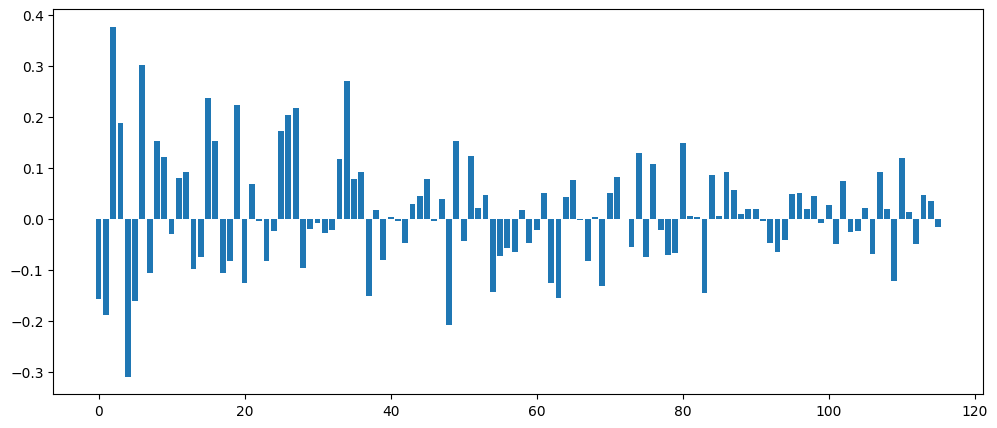

In [16]:
plt.figure(figsize=(12,5))
plt.bar(range(116),PCA_train[30])
plt.show()

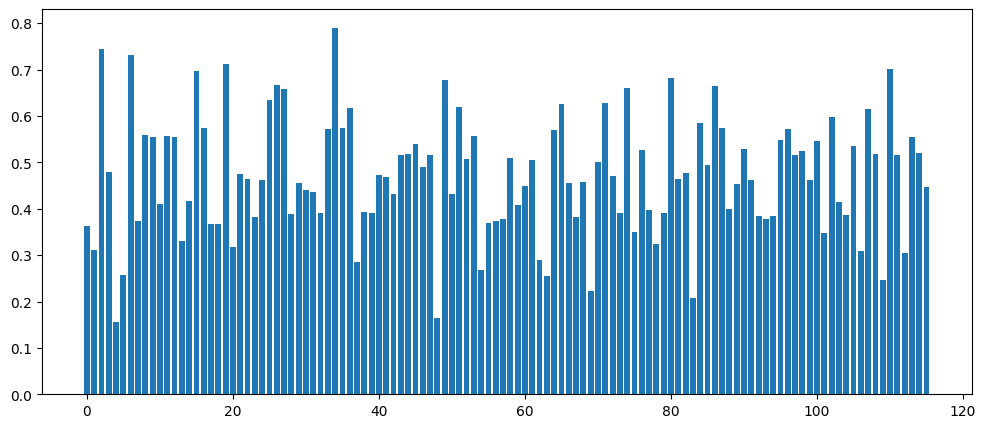

In [17]:
plt.figure(figsize=(12,5))
plt.bar(range(116),PCA_01_train[30])
plt.show()

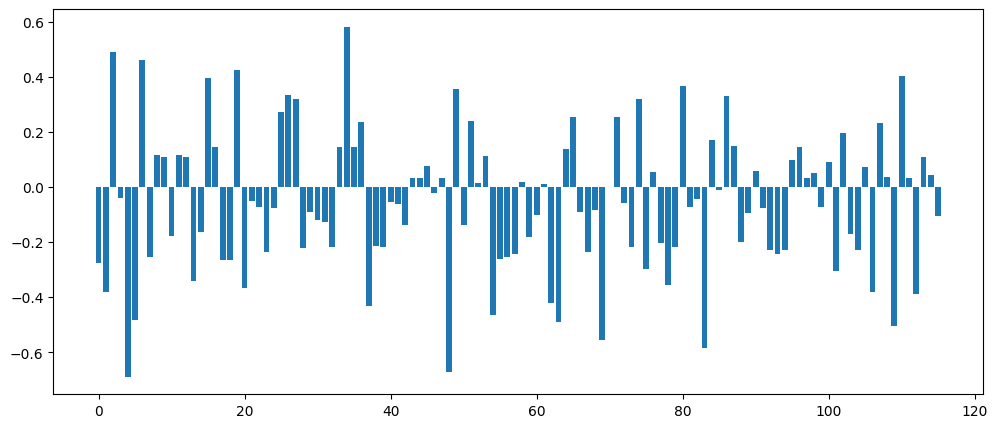

In [18]:
plt.figure(figsize=(12,5))
plt.bar(range(116),PCA_11_train[30])
plt.show()

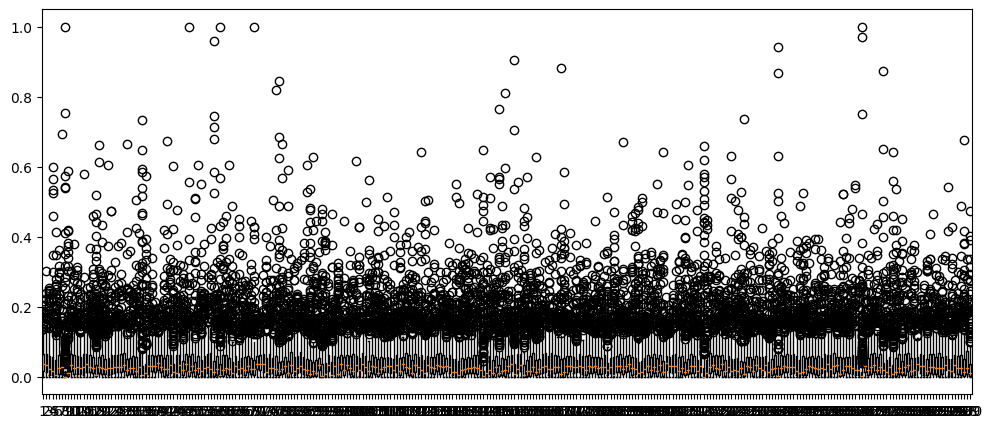

In [19]:
plt.figure(figsize=(12,5))
plt.boxplot(normalized_01_train[::50].T)
plt.show()

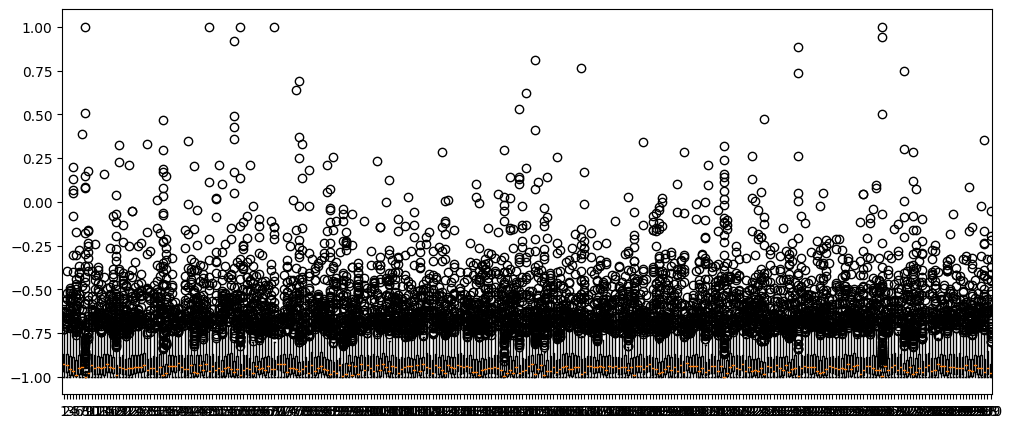

In [20]:
plt.figure(figsize=(12,5))
plt.boxplot(normalized_11_train[::50].T)
plt.show()

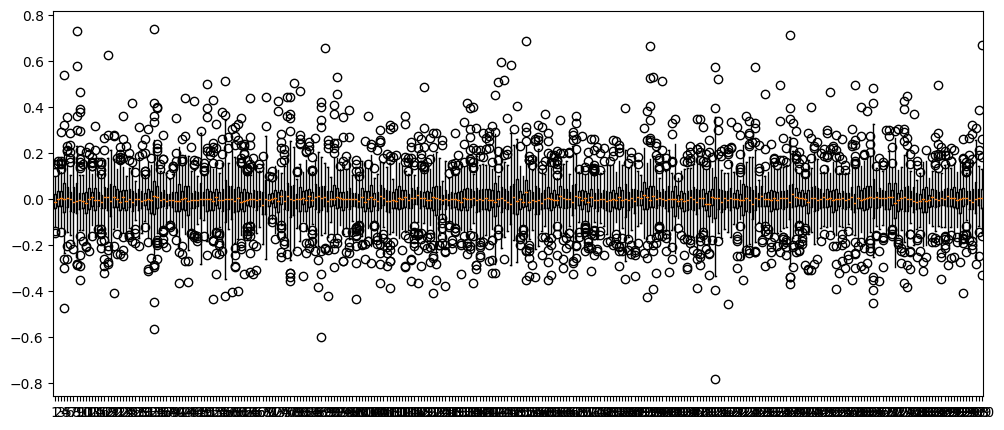

In [21]:
plt.figure(figsize=(12,5))
plt.boxplot(PCA_train[::50].T)
plt.show()

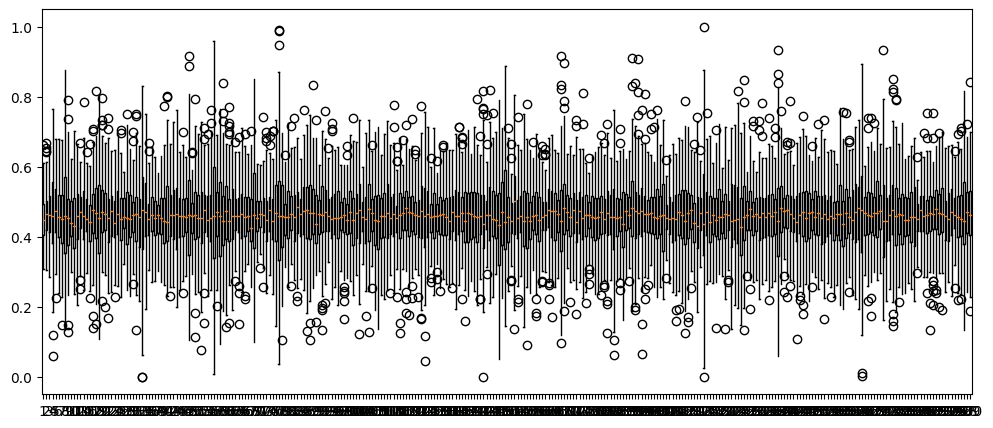

In [22]:
plt.figure(figsize=(12,5))
plt.boxplot(PCA_01_train[::50].T)
plt.show()

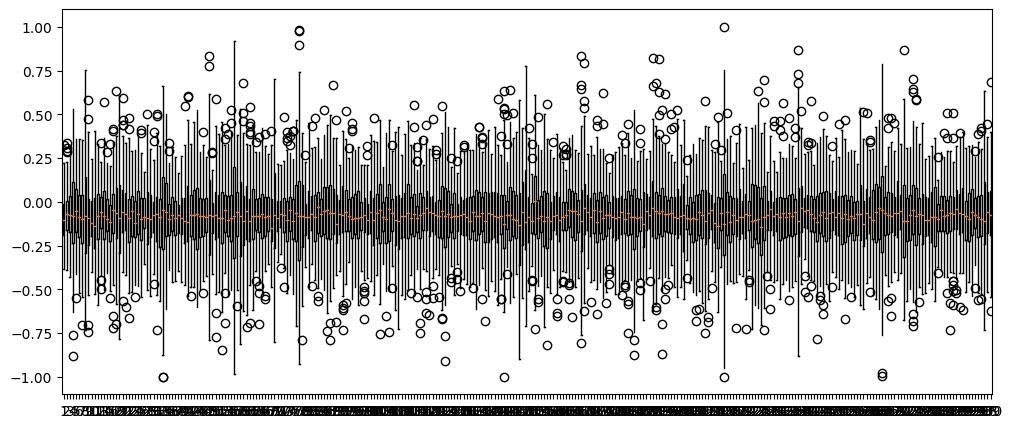

In [23]:
plt.figure(figsize=(12,5))
plt.boxplot(PCA_11_train[::50].T)
plt.show()

## Introduction to scikit-learn

[Scikit-learn](https://scikit-learn.org/stable/) is a very well documented machine learning library in Python. It contains many algorithms for [classification](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning), and makes the whole process of building a machine learning pipeline relatively straightforward. There are many examples in the documentation, as well as relatively complete theoretical explanations, so I really encourage you to take the time to read it if some things are not clear.

Let's make a very simple example. We are going to use the [Ridge Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html#sklearn.linear_model.RidgeClassifier), which is a very basic linear model.

In [24]:
from sklearn.linear_model import RidgeClassifier

# objective: minimizing of the MSE but also adds a regularization param to keep the weights as low as possible
#          -> try to avoid overfitting while fitting the data


To use a classifier with scikit-image, we generally have three steps:

* Create an instance of the class of the classifier (here: RidgeClassifier). The constructor will generally contain many arguments that can be modified, and that are explained in the documentation. There will also generally be default values for all of them, so in this simple example we will just use those:

In [25]:
clf = RidgeClassifier()

* Use the *fit* method with, as arguments, the training data (in our case, the HoG vectors) and the corresponding labels. This will start the main training algorithm, trying to fit the parameters of the classifier with the training data:

In [26]:
clf.fit(dataset.train['hog'], dataset.train['labels'])

RidgeClassifier()

* Use the *predict* method to get the prediction of the classifier on the data given as argument. In this case, we get the predictions on the data that was just used for training. **What kind of performance will that give us?**

In [27]:
pred = clf.predict(dataset.train['hog'])
print(pred.shape)


(15000,)


We can then evaluate those predictions. Scikit-learn provides many different [metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) for evaluating the performances of a classifier. The most simple of those is the accuracy, which is simply the number of correct predictions divided by the total number of predictions:

In [28]:
from sklearn.metrics import accuracy_score

score = accuracy_score(dataset.train['labels'], pred)
print(score)

# Not that it's fairly easy to compute that score "by hand":
T = (pred==dataset.train['labels']).sum()
print(T, len(pred), T/len(pred))

# It is ok to use the accuracy because our dataset is balanced, otherwise, would have been tricky

0.7356666666666667
11035 15000 0.7356666666666667


In a multiclass problem, it's often also very useful to look at the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix), which gives us more information on which classes are often mistaken for each other:

In [65]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(dataset.train['labels'], pred)
print(cm)


# Nice to see if some classes are harder to separate
# row = true val, column = prediction

[[3812  740  448]
 [ 742 3236 1022]
 [ 337  676 3987]]


In [66]:
pred =  clf.predict(dataset.test['hog'])
print(pred.shape)

score = accuracy_score(dataset.test['labels'], pred)
print(score)


(3000,)
0.729


In [67]:
#Quick questions:

#The dataset has already been split into a training set (dataset.train) and a test set (dataset.test).

#How many images are in the training set ?
#How many images are in the test set ?
#What is the class distribution of the dataset ?

In [68]:
p_val = 0.1
n_val = int(p_val* len(dataset.train['hog']))

train_X = dataset.train['hog'][:-n_val]
train_Y = dataset.train['labels'][:-n_val]

val_X = dataset.test['hog'][-n_val:]
val_Y = dataset.test['labels'][-n_val:]

print(len(train_X), len(train_Y))
print(len(val_X), len(val_Y))


13500 13500
1500 1500


In [69]:
clf = RidgeClassifier(alpha = 0.1)
clf.fit(train_X, train_Y)

pred = clf.predict(val_X)
pred_descr = clf.predict(train_X)

descr_score = accuracy_score(train_Y, pred_descr)
pred_score =  accuracy_score(val_Y, pred)


print(f'Descriptivre score: {descr_score}')
print(f'Predictive score: {pred_score}')


cm = confusion_matrix(val_Y, pred)
print(cm)

print(cm.sum(axis=1))

# Predictive always lower than, decriptive but if significantly lower, maybe overfitting

# here, i just take the last 10% to split, it is ok because it is almost balanced. 
#But if the data was ordered, I would need to shuffle my data befire splitting it

# I could use the stratifiedKFold to be sure that my data will always be correctly split

Descriptivre score: 0.7562222222222222
Predictive score: 0.7486666666666667
[[400  76  35]
 [ 61 326 101]
 [ 23  81 397]]
[511 488 501]


In [70]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
ridge_clf = RidgeClassifier()

accuracies = []

for train_index, val_index in skf.split(dataset.train['hog'], dataset.train['labels']):
    X_train, X_val = dataset.train['hog'][train_index], dataset.train['hog'][val_index]
    y_train, y_val = dataset.train['labels'][train_index], dataset.train['labels'][val_index]

    ridge_clf.fit(X_train, y_train)
    y_pred = ridge_clf.predict(X_val)
    
    accuracy = accuracy_score(y_val, y_pred)
    print("Accuracy:", accuracy)
    accuracies.append(accuracy)

    
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)




Accuracy: 0.716
Accuracy: 0.7206666666666667
Accuracy: 0.7453333333333333
Accuracy: 0.722
Accuracy: 0.7333333333333333
Accuracy: 0.7413333333333333
Accuracy: 0.7266666666666667
Accuracy: 0.7153333333333334
Accuracy: 0.7346666666666667
Accuracy: 0.7313333333333333
Mean Accuracy: 0.7286666666666667
Standard Deviation of Accuracy: 0.009766154707855976


In [71]:
# The cross validation can be really useful to create the separation between 
# the train and the validation sets over and over and average the the scores

# Here the model is stable

## How can we find the "best" algorithm?

What we have shown above served to illustrate how scikit-learn classifiers work, but we now have to build a valid machine learning pipeline to compare the different algorithms that we will use in the next labs.

As we have said earlier, we have already split the dataset into a "training" and a "test" set. It is clear that the final evaluation should take place on the test set.

But in addition to comparing the algorithms between each other, we also have to find the best "hyper-parameters" for each algorithm. For example, in our RidgeClassifier example, there is a regularization parameters, *alpha*, which by default was set to 1.0. Can we improve the performance of the algorithm by modifying this parameter ?

### Side-note: parameter vs hyper-parameter

In general, when talking about machine learning models, **parameters** are what the algorithm learns with the data (if we are for instance learning a linear regression y = ax+b, the "parameters" would be a and b), while **hyper-parameters** are modifiers to the model or to the pipeline (for instance, if we are generalizing to a polynomial regression, the degree of the polynome would be an hyper-parameter).

### Cross-validation

The most common way of finding the best hyper-parameters of a classifier is to use [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

* Using the [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) method from scikit-learn, find the best *alpha* hyper-parameter for the RidgeClassifier: 

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifier



parameter_space = {
    'alpha': [0.01, 0.05, 0.06, 0.07, 0.1, 0.2, 0.5, 0.75, 1, 5, 10, 20, 50, 75, 100] 
    
}

clf = RidgeClassifier()


grid_search = GridSearchCV(estimator=clf, param_grid=parameter_space, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(dataset.train['hog'], dataset.train['labels'])

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

best_svc = grid_search.best_estimator_
best_svc.fit(dataset.train['hog'], dataset.train['labels'])

test_accuracy = best_svc.score(dataset.test['hog'], dataset.test['labels'])
print("Test Accuracy with Best Model:", test_accuracy)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Parameters: {'alpha': 0.05}
Best Score: 0.7454000000000001
Test Accuracy with Best Model: 0.743


### Comparing algorithms

Once you have found the best hyper-parameters for an algorithm, you can re-train the classifier on the whole training set, and finally use the test set to get a "final performance". 

* How can you then decide which of the classifiers is best ?
* How can you decide if the different between two classifiers is significant ?

Try to compare the best RidgeClassifier with the original. Is it significantly better?

In [31]:
## Optimized model

clf = RidgeClassifier()
clf.fit(dataset.train['hog'], dataset.train['labels'])

pred = clf.predict(dataset.test['hog'])
score = accuracy_score(dataset.test['labels'], pred)
print(score)


0.729


In [32]:
## Optimized model

clf = RidgeClassifier(alpha = 0.05)
clf.fit(dataset.train['hog'], dataset.train['labels'])

pred = clf.predict(dataset.test['hog'])
score = accuracy_score(dataset.test['labels'], pred)
print(score)



0.743


In [ ]:
# Because the dataset is balanced we can use the accuracy as a metric and it shows us that the optimized model 
# is a better classifier than the default one.